# Combustion stationnarity study
This part is dedicated to look for the time where:
1. the mass fraction quantity is stable
2. Temperature and mass fraction quantity are stable

$\color{red}{NOTE}:$ the code mainly obtained from combustion.ipynb/ combustion_with_T.ipynb/ refer to these for more details

## Fixed Temperature (Ignition) 

In [5]:
%matplotlib widget
import matplotlib.pyplot as plt
import numpy as np 
from numba import jit
from numpy import sin, pi
from pathlib import Path

%reload_ext autoreload
%aimport Funcs
%aimport visualization
%aimport species_transport
%aimport parameters
from parameters import *
from fluid_flow import dt_fluid_flow
from visualization import plot_species_overview, plot_velocity_vector_field
from species_transport import evolve_species, set_up_T
from Funcs import metric_L0, metric_RMS

In [16]:
N, M = 50,50
dx, dy, Ns_c, Nc_lw = parameters.set_resolution(N,M)
dt = dt_fluid_flow(dx, Fo=0.3)

# load the velocity field:
data_vel = Path('data/vel_field') / 'N{}M{}.npy'.format(N,M)
u,v = np.load(data_vel)

# load the species and temperature fields as computed in the pre-combustion phase:
data_sp = Path('data/species') / 'N{}M{}.npy'.format(N,M)
species_data = np.load(data_sp)
Y = species_data[:-1,:, :]
T = species_data[-1, :, :]
T = set_up_T(N,M, dy, smooth=False)
species_names = ['CH$_4$', 'O$_2$', 'N$_2$',  'H$_2$O', 'CO$_2$']
print(Y.shape)

(5, 50, 50)


In [17]:
#same technique as fluid_flow.ipynb
Tt     = 0.15
Nt     = 1
N_loop = int(Tt/dt/Nt)
Nt0    = 1
L0     = np.zeros((len(species_names)+1,N_loop))
L2     = np.zeros_like(L0)
Y, _ = evolve_species(Nt0, Y, T, dt, u, v, dx, dy, Ns_c, Nc_lw, chem=True, dt_chem=6.4e-7, evolve_T=False)
for i in range(N_loop):
    Y_old = Y.copy()
    Y, _ = evolve_species(Nt, Y, T, dt, u, v, dx, dy, Ns_c, Nc_lw, chem=True, dt_chem=6.4e-7, evolve_T=False)
    for j in range(len(species_names)+1):
        L0[j,i] = metric_L0(Y_old, Y)
        L2[j,i] = metric_RMS(Y_old, Y)



Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
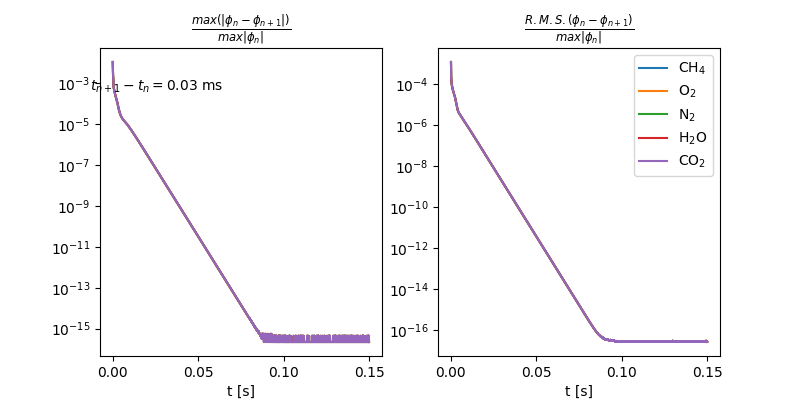

In [20]:
Tt = np.arange(N_loop) * dt * Nt + dt * Nt0

fig, [ax, ax2] = plt.subplots(1,2, figsize=(8,4), sharex=True)
for i in range(len(species_names)):
    ax.plot(Tt, L0[i], label=species_names[i])
    ax2.plot(Tt, L2[i], label=species_names[i])

    ax.set_title(r'$\frac{ max ( |\phi_n - \phi_{n+1}| ) } { max |\phi_n| }$')
    ax2.set_title(r'$\frac{ R.M.S.( \phi_n - \phi_{n+1} ) }{ max |\phi_n| }$')
ax.set_xlabel('t [s]')
ax2.set_xlabel('t [s]')
if True:
    ax.set_yscale('log')
    ax2.set_yscale('log')
    #ax.set_xscale('log')
    #ax2.set_xscale('log')
s = r'$t_{n+1} - t_n = $' +'${:.2f}$ ms'.format(Nt * dt * 1e3)
ax.text(0.2, 0.9, s, verticalalignment='top', horizontalalignment='center', transform=ax.transAxes)
plt.legend()


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
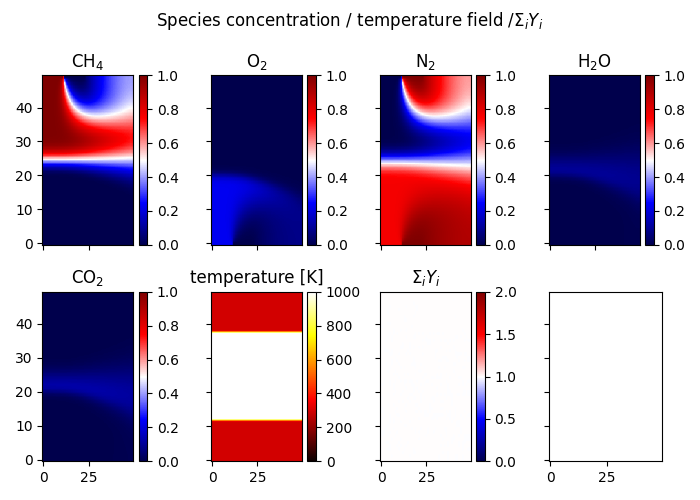

In [19]:
%autoreload 1
fig, axs =plt.subplots(2, 4, figsize=(7,5.),sharex=True, sharey=True)
plot_species_overview(Y,T, axs=axs)